# Sentence correction gpt on Korean

한국어 문법교정 BART 모델 구축하기


Google Colab 환경에서 실행시 이 라인을 먼저 실행한다.

In [ ]:
# only google cloab
import os, sys
from google.colab import drive
drive.mount('/content/drive')

LOCATION = '/content/drive/MyDrive/spell_correction'

Local 환경에서 실행시 이 라인을 먼저 실행한다.

In [2]:
LOCATION = '.'

In [ ]:
%pip install pandas numpy scipy scikit-learn torch accelerate transformers ipywidgets tqdm matplotlib datasets evaluate --upgrade

# Transformers 를 사용하기 위한 라이브러리들 설치

### AI-Hub data 정제

예시 데이터는 다음과 같다.

이 프로젝트를 수행하는 데이터인 AI-Hub 데이터는 용량이 112GB, 국외반출 불가로 데이터 관리에 주의를 요한다.

이 데이터를 Pandas.DataFrame['index', text', 'corrected'] 로 정제하는 과정을 거친다.

```json
{  "id": "100008-1-1-1",
  "fileName": "TX_CA_1_100008-1-1-1",
  "dataSet": "한국어 철자 및 맞춤법 교정용 병렬 데이터",
  "domain": "CA",
  "ko": "지금까지 다녀 본 여행지 중 좋았던 곳 추천해줘.",
  "corrected": "지금까지 다녀 본 여행지 중 좋았던 곳 추천해 줘.",
  "error": [
    {
      "errorType": "spac",
      "startPoint": 22,
      "endPoint": 27
    }
  ]
}
```

# 아래의 셀은 반드시 Local 환경에서 실행한다.

In [ ]:
from typing import List, Dict

from json_processing import get_json_files, read_json_file

import pandas as pd

train = get_json_files(f'{LOCATION}/data/train')
validate = get_json_files(f'{LOCATION}/data/validate')

train_data = pd.DataFrame()
validate_data = pd.DataFrame()

In [ ]:
from json_processing import get_json_files, read_json_file
from tqdm.notebook import tqdm

import multiprocessing as mp

# https://zerohertz.github.io/multiprocessing/
with mp.Pool() as pool:
    train_raw = list(tqdm(pool.imap(read_json_file, train), total=len(train)))

train_data = pd.concat(train_raw, ignore_index=True)

for file in tqdm(validate):
    validate_data = pd.concat([validate_data, read_json_file(f'{LOCATION}/{file}')], ignore_index=True)

for data in [train_data, validate_data]:
    data.dropna(subset=['text'], inplace=True)
    data.dropna(subset=['corrected'], inplace=True)

train_data.to_csv(f'{LOCATION}/train.csv')
validate_data.to_csv(f'{LOCATION}/validate.csv')

### 문장 분포 확인

Transformer API를 이용해 학습시키기 위해, 텍스트의 Max Length를 알아보도록 한다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sentents = pd.concat([pd.read_csv(f'{LOCATION}/train.csv'), pd.read_csv(f'{LOCATION}/validate.csv')])

# 각 문장의 길이 계산
text_lengths = sentents['text'].apply(lambda x: len(str(x)))
corrected_lengths = sentents['corrected'].apply(lambda x: len(str(x)))

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.hist([text_lengths, corrected_lengths], bins=100, color=['blue', 'orange'], label=['text', 'corrected'])
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.grid(True)

plt.xlim(0, 220)

plt.text(text_lengths.max(), 100, f"Max: {text_lengths.max()}", ha='right', va='center', color='blue', fontsize=10)
plt.text(corrected_lengths.max(), 100, f"Max: {corrected_lengths.max()}", ha='right', va='center', color='orange', fontsize=10)

plt.show()

# 'text' 열의 각 문장의 길이 계산
sentents['text_length'] = sentents['text'].apply(lambda x: len(str(x)))
sentents['corrected_length'] = sentents['corrected'].apply(lambda x: len(str(x)))

# 가장 긴 문장 10개 추출
top_longest_text = sentents.nlargest(10, 'text_length')
top_longest_corrected = sentents.nlargest(20, 'corrected_length')

for idx, value in top_longest_text.iterrows():
    print(value['id'], value['text'])
print("=====================")
for idx, value in top_longest_corrected.iterrows():
    print(value['id'], value['corrected'])

In [ ]:
top_longest_corrected.to_csv(f'{LOCATION}/errors.csv')

### 오류문장 정정

```
Search8151751스포츠/생활 건강이런 음식들은 머리카락에 영양을 공급하고 윤기가 나게 해줄 수 있다.대기8151752스포츠/생활 건강이런 음식들은 피부 또한 부드럽게 만들어 준다.대기8151753스포츠/생활 건강탈모가 지속될 경우 호르몬 불균형 문제일 수 있 수 있다.대기8151754스포츠/생활 건강정관수술은 정자의 이동통로인 정관을 절단하고 결찰한다.대기8151755스포츠/생활 건강정관수술은 사정액 내에 정자가 함께 배출되는 것을 막는 수술이다.대기8151756스포츠/생활 건강자녀를 가진 부부가 자녀의 계획이 없는 경우 정관수술을 시행할 수 있다.대기8151757스포츠/생활 건강정관수술 후 바로 성관계할 수 있다.대기8151758스포츠/생활 건강문제는 일정 기간 아직 남아 있는 정자들로 임신이 가능할 수 있다.대기8151759스포츠/생활 건강정관수술 후 수회 이상 기타 피임을 통해 정자들을 모두 배출시켜야 한다.대기8151760스포츠/생활 건강정관수술 이후 정액검사를 통해 무정자증을 확인하는 것도 좋은 방법이다.대기101-10 of 35원본 문장 오류 태깅이런음식들은피부또한부드럽게만들어준다.오류 태깅ㅤ만들어준다.띄어쓰기 오류원본 텍스트이런 음식들은 피부 또한 부드럽게 만들어 준다.
```
다음과 같은 오류문장이 포함되어 있다. 해당부분을 수동으로 정정해주어야 한다. 해당 부분을 정정하기 위해 AI-Hub에 오류정정을 제기한 상태이다.

![](dist-length.png)

### Transformer 학습 준비

학습 준비된 데이터는 토크나이저를 불러와 DataLoader에 준비하여 학습 준비를 한다.

파인튜닝 대상 모델은 다음과 같다.
[SKT-AI/KoBART](https://github.com/SKT-AI/KoBART)

In [ ]:
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizerFast
from typing import Tuple

import pandas as pd
import numpy as np
import torch

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v2', bos_token="<s>", eos_token="</s>")
max_length = 128

print(f"BOS_TOKEN: {tokenizer.bos_token}, EOS_TOKEN: {tokenizer.eos_token}")

class TextDataset(Dataset):
    def __init__(self, file_path: str, tokenizer, max_length, chunksize=3000):
        self.file_path = file_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.chunksize = chunksize
        self.bos_token = self.tokenizer.bos_token
        self.eos_token = self.tokenizer.eos_token
        
        self.reader = pd.read_csv(file_path)

    def __len__(self):
        return len(self.reader)

    def __getitem__(self, idx):
        row = self.reader.iloc[idx]
        input_text = str(row['text'])
        corrected_text = str(row['corrected'])
        
        input_encodings = self.tokenizer.encode_plus(
            self.bos_token + input_text + self.eos_token,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        output_encodings = self.tokenizer.encode_plus(
            self.bos_token + corrected_text + self.eos_token,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        
        input_ids = input_encodings['input_ids'].squeeze()
        attention_mask = input_encodings['attention_mask'].squeeze()
        output_ids = output_encodings['input_ids'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': output_ids
        }

train_dataset = TextDataset(f'{LOCATION}/train.csv', tokenizer, max_length)
validate_dataset = TextDataset(f'{LOCATION}/validate.csv', tokenizer, max_length)

In [ ]:
from transformers import BartForConditionalGeneration, Trainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, TrainerCallback
from evaluate import load

import torch
import pickle
import os
import gc

device = torch.device('cpu')

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')

model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v2')
lr=2e-5
SAVE_PATH = f"{LOCATION}/all_metrics.csv"
metric_bleu = load("bleu")
metric_rouge = load("rouge")
metric_meteor = load("meteor")

if os.path.exists(SAVE_PATH):
    all_metrics = pd.read_csv(SAVE_PATH)
else:
    all_metrics = pd.DataFrame(columns=["train_loss", "val_loss", "bleu", "rouge", "meteor"])

def get_latest_checkpoint(path):
    checkpoints = [f for f in os.listdir(path) if f.startswith('checkpoint-')]
    if checkpoints:
        return os.path.join(path, max(checkpoints))
    else:
        return None

def compute_metrics(eval_pred: Tuple[torch.Tensor, torch.Tensor]):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.array(labels)
    neg_labels = labels < 0
    if np.any(neg_labels):
        labels[neg_labels] = 0

    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu_score = metric_bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    rouge_score = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_score = metric_meteor.compute(predictions=decoded_preds, references=decoded_labels)
    score = {"bleu": bleu_score["bleu"], "rouge": rouge_score['rougeL'], "meteor": meteor_score["meteor"], "train_loss": eval_pred.metrics["train_loss"], "val_loss": eval_pred.metrics["eval_loss"],}

    all_metrics.loc[len(all_metrics)] = score
    all_metrics.to_csv(SAVE_PATH)

    return score

def preprocess_logits_for_metrics(logits, labels):
        if isinstance(logits, tuple):
            # Depending on the model and config, logits may contain extra tensors,
            # like past_key_values, but logits always come first
            logits = logits[0]
        return logits.argmax(dim=-1)

class EmptyCacheCallback(TrainerCallback):
    """훈련의 각 로그 스텝마다 CUDA 캐시를 비우는 콜백"""

    def on_log(self, args, state, control, **kwargs):
        """로그 이벤트가 발생할 때 CUDA 캐시를 비웁니다."""
        gc.collect()
        torch.mps.empty_cache()

data_collactor = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    eval_accumulation_steps=8,
    output_dir=f"{LOCATION}/model-bart", # 모델 저장 경로
    overwrite_output_dir=True,  # 기존 모델을 덮어쓰기
    learning_rate=lr,  # 학습률 설정
    num_train_epochs=20,  # 학습 에포크 설정
    evaluation_strategy="epoch",  # 평가 스트레티지 설정
    per_device_train_batch_size=16,  # 배치 크기 설정
    per_device_eval_batch_size=16,
    save_steps=1000,  # 모델 저장 스텝 설정
    save_total_limit=10,  # 최대 모델 저장 개수 설정
    warmup_steps=500,  # 워밍업 스텝 설정
    weight_decay=0.01,
    predict_with_generate=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    data_collator=data_collactor,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[EmptyCacheCallback()],
)

trainer.train(resume_from_checkpoint = True if get_latest_checkpoint(f'{LOCATION}/model-bart') else False)
trainer.evaluate()

trainer.save_model(f"{LOCATION}/bart")


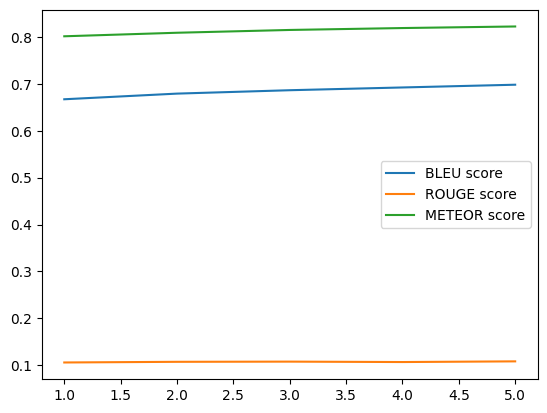

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

SAVE_PATH = f"{LOCATION}/all_metrics.csv"
df_metrics = pd.read_csv(SAVE_PATH)

x_ticks = np.arange(1, len(df_metrics) + 1)

# 그래프 시각화
plt.plot(x_ticks, df_metrics["bleu"], label="BLEU score")
plt.plot(x_ticks, df_metrics["rouge"], label="ROUGE score")
plt.plot(x_ticks, df_metrics["meteor"], label="METEOR score")
plt.legend()
plt.show()

![](learning.png)